# Structure Data for BPNN

In [10]:
%load_ext autoreload
%autoreload 2

from Dataset import *
import numpy as np
from bpnn_cuda import BPNN
from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the Model

In [11]:

import pickle
import gzip
# Load the best model from file
with gzip.open('models/bpnn_best_model.pkl.gzip', 'rb') as f:
    nn = pickle.load(f)

# Evaluate Model

In [12]:
def evaluate(dataset, name):

    acc = 0
    acc0 = 0
    len0 = 0
    acc1 = 0
    len1 = 0

    for (x, y) in dataset:
        decision = np.argmax(nn.feedforward(x))

        if decision == y:
            acc += 1
        if y == 0:
            len0 += 1
            if decision == y:
                acc0 += 1
        if y == 1:
            len1 += 1
            if decision == y:
                acc1 += 1

    nn_acc = acc / (len0 + len1)
    # Compute class accuracies
    nn_acc0 = acc0 / len0
    nn_acc1 = acc1 / len1

    print(f'Overall {name} Accuracy: {nn_acc}')
    print(f'Class 0 {name} Accuracy: {nn_acc0}')
    print(f'Class 1 {name} Accuracy: {nn_acc1}')

    return nn_acc, nn_acc0, nn_acc1


training_data, validation_data, testing_data, ndimen = BPNN.get_data()


vnn_acc, vnn_acc0, vnn_acc1 = evaluate(validation_data, "Validation")
print()
tnn_acc, tnn_acc0, tnn_acc1 = evaluate(testing_data, "Testing")


Overall Validation Accuracy: 0.95625
Class 0 Validation Accuracy: 0.9425
Class 1 Validation Accuracy: 0.97

Overall Testing Accuracy: 0.9425403225806451
Class 0 Testing Accuracy: 0.9410609037328095
Class 1 Testing Accuracy: 0.9440993788819876


# Plot Bar Chart

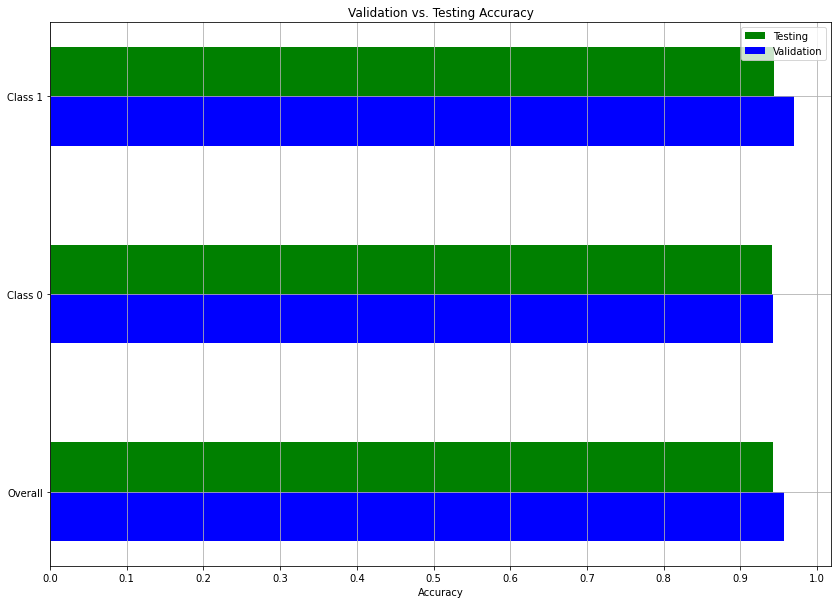

In [13]:
# Plot a barchart comparing the validation vs testing accuracies overall, for class 0, and for class 1 side by side

# set the y axis major ticks to .1 and minor ticks to .01
major_ticks = np.arange(0, 1.1, 0.1)
minor_ticks = np.arange(0, 1.1, 0.01)



fig = plt.figure(figsize=(14, 10))

plt.title(f"Validation vs. Testing Accuracy")
plt.xlabel("Accuracy")

width = 0.25
plt.barh(0 + width/2, tnn_acc, width, label='Testing', color='green')
plt.barh(0 - width/2, vnn_acc, width, label='Validation', color='blue')

plt.barh(1 + width/2, tnn_acc0, width, color='green')
plt.barh(1 - width/2, vnn_acc0, width, color='blue')

plt.barh(2 + width/2, tnn_acc1, width, color='green')
plt.barh(2 - width/2, vnn_acc1, width, color='blue')

plt.yticks(np.arange(0, 3, 1), ['Overall', 'Class 0', 'Class 1'])
plt.xticks(major_ticks)
plt.grid()
plt.legend()
plt.show()
fig.savefig(f'img/bpnn_validation_vs_testing', dpi=100)
